### Ideas
* Try DenseNet, SqueezeNet , 
* Repeat Experiment30+
* Train 200 models, get the median of top 100 models on validations . use different seeds
* Predict using inc_angle , no. of samples , mean of sample , median of samples - logistic regression / KNN Regressor
* Try Hyperas
* Compare RMSProp , Adam, SGD + Momentum + Nesterov, Adamax, different learning rates


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

import seaborn as sb


import cv2

from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

#Import Keras.
from matplotlib import pyplot

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation, GlobalMaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras import initializers
from keras.optimizers import RMSprop, Adam, SGD
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping,ReduceLROnPlateau

from keras.applications.vgg16 import preprocess_input
from keras.models import load_model
from keras import backend as K


Using TensorFlow backend.


In [2]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.densenet import DenseNet121

In [3]:
train = pd.read_json("data/processed/train.json")
test = pd.read_json("data/processed/test.json")

In [4]:
train[train['inc_angle']=='na'] = train[train['inc_angle']!='na']['inc_angle'].mean()

In [6]:
train.head(3)
train["is_iceberg"].value_counts()

0    851
1    753
Name: is_iceberg, dtype: int64

In [16]:
# icebergs = train[train.is_iceberg==1].sample(n=9,random_state=123)
# ships = train[train.is_iceberg==0].sample(n=9,random_state=456)
# icebergs['band_1'][733]

In [17]:
# Plot band_2
# fig = plt.figure(1,figsize=(15,15))
# for i in range(9):
#     ax = fig.add_subplot(3,3,i+1)
#     arr = np.reshape(np.array(ships.iloc[i,1]),(75,75))
#     ax.imshow(arr,cmap='inferno')
    
# plt.show()

In [18]:
# Plot band_2
# fig = plt.figure(1,figsize=(15,15))
# for i in range(9):
#     ax = fig.add_subplot(3,3,i+1)
#     arr = np.reshape(np.array(icebergs.iloc[i,1]),(75,75))
#     ax.imshow(arr,cmap='inferno')
    
# plt.show()

In [19]:
print(len(train),len(test))

1604 8424


In [4]:
#Generate the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_band_3=(X_band_1+X_band_2)/2
# Axis = 1 refers to adding based on the last dimension
train_image = np.concatenate([X_band_1[:, :, :, np.newaxis]
                          , X_band_2[:, :, :, np.newaxis]
                         , X_band_3[:, :, :, np.newaxis]], axis=-1)

train_target =train['is_iceberg']
train_angle = train['inc_angle']

X_band_1s = X_band_1 - X_band_1.mean() / (X_band_1.max()-X_band_1.min())
X_band_2s = X_band_2 - X_band_2.mean() / (X_band_2.max()-X_band_2.min())
X_band_3s = (X_band_1s+X_band_2s)/2

train_image_scaled = np.concatenate([X_band_1s[:, :, :, np.newaxis]
                                     , X_band_2s[:, :, :, np.newaxis]
                                     , X_band_3s[:, :, :, np.newaxis]], axis=-1)


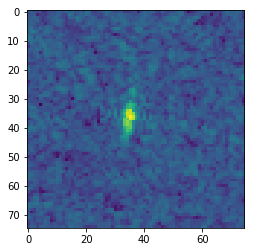

In [5]:
plt.imshow(train_image[0][:,:,0])

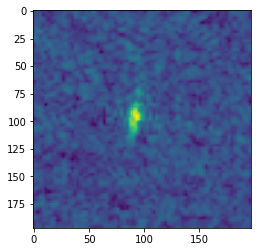

In [48]:
plt.imshow(train_image_resize[0][:,:,0])

In [15]:
print(X_band_1.min(),X_band_1.max(),X_band_1.mean())
print(X_band_2.min(),X_band_2.max(),X_band_2.mean())


-45.5944 34.5749 -20.6558
-45.6555 20.1542 -26.3207


In [6]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_band_test_3=(X_band_test_1+X_band_test_2)/2
test_image = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , X_band_test_3[:, :, :, np.newaxis]], axis=-1)

test_angle = test['inc_angle']


X_band_test_1s = X_band_test_1 - X_band_test_1.mean() / (X_band_test_1.max()-X_band_test_1.min())
X_band_test_2s = X_band_test_2 - X_band_test_2.mean() / (X_band_test_2.max()-X_band_test_2.min())
X_band_test_3s = (X_band_test_1s+X_band_test_2s)/2
test_image_scaled = np.concatenate([X_band_test_1s[:, :, :, np.newaxis]
                                    , X_band_test_2s[:, :, :, np.newaxis]
                                    , X_band_test_3s[:, :, :, np.newaxis]], axis=-1)

In [7]:
#resize
train_image_resize = np.array([cv2.resize(t,(197,197)) for t in train_image])
test_image_resize = np.array([cv2.resize(t,(197,197)) for t in test_image])

In [ ]:
print(train_image.shape,X_band_1.shape,train_image.shape[1:])

In [ ]:
# https://github.com/chenjennhaur/courses/blob/master/deeplearning2/densenet-keras.ipynb
    
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization(mode=0, axis=-1)(x)
def relu_bn(x): return relu(bn(x))

def conv(x, nf, sz, wd, p):
    x = Convolution2D(nf, sz, sz, init='he_uniform', border_mode='same', 
                          W_regularizer=l2(wd))(x)
    return dropout(x,p)

def conv_block(x, nf, bottleneck=False, p=None, wd=0):
    x = relu_bn(x)
    if bottleneck: x = relu_bn(conv(x, nf * 4, 1, wd, p))
    return conv(x, nf, 3, wd, p)

def dense_block(x, nb_layers, growth_rate, bottleneck=False, p=None, wd=0):
    if bottleneck: nb_layers //= 2
    for i in range(nb_layers):
        b = conv_block(x, growth_rate, bottleneck=bottleneck, p=p, wd=wd)
        x = merge([x,b], mode='concat', concat_axis=-1)
    return x

def transition_block(x, compression=1.0, p=None, wd=0):
    nf = int(x.get_shape().as_list()[-1] * compression)
    x = relu_bn(x)
    x = conv(x, nf, 1, wd, p)
    return AveragePooling2D((2, 2), strides=(2, 2))(x)

def create_dense_net(nb_classes, img_input, depth=40, nb_block=3, 
     growth_rate=12, nb_filter=16, bottleneck=False, compression=1.0, p=None, wd=0, activation='softmax'):
    
    assert activation == 'softmax' or activation == 'sigmoid'
    assert (depth - 4) % nb_block == 0
    nb_layers_per_block = int((depth - 4) / nb_block)
    nb_layers = [nb_layers_per_block] * nb_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    for i,block in enumerate(nb_layers):
        x = dense_block(x, block, growth_rate, bottleneck=bottleneck, p=p, wd=wd)
        if i != len(nb_layers)-1:
            x = transition_block(x, compression=compression, p=p, wd=wd)

    x = relu_bn(x)
    x = GlobalAveragePooling2D()(x)
    return Dense(nb_classes, activation=activation, W_regularizer=l2(wd))(x)

In [40]:
def getVggModel():
    input_1 = Input(shape=train_image.shape[1:],name='pic')
    input_2 = Input(shape=[1], name="angle")
    # Do batch normalization
    
    
    base_model = VGG16(weights='imagenet', include_top=False)
    
#     for layer in base_model.layers[:-1]:
#         layer.trainable = False
    
    x = base_model.get_layer('block5_pool').output
    x = GlobalMaxPooling2D()(x)
#     x = Dense(512)(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Dropout(0.2)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(base_model.input,predictions)
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    adam = Adam()
    model.compile(loss='binary_crossentropy',optimizer=sgd,metrics=['accuracy'])    
#     model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
    return model

# Debugging
# for layers in testmodel.layers:
#     print(layers)

In [13]:
def getResNet50():
    
    base_model = ResNet50(weights='imagenet', include_top=False)
    
#     for layer in base_model.layers[:-1]:
#         layer.trainable = False    
    
    x = base_model.layers[-1].output
    x = GlobalMaxPooling2D()(x)  
#     x = GlobalMaxAveragePooling2D()(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(base_model.input,out)
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    adam = Adam()
    model.compile(loss='binary_crossentropy',optimizer=sgd,metrics=['accuracy'])
    
    return model

In [51]:
def getModel():
    #Build keras model
    
    model=Sequential()
    
    # CNN 1
    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 2
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    #CNN 4P
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # You must flatten the data for the dense layers
    model.add(Flatten())

    #Dense 1
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    #Dense 2
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    # Output 
    model.add(Dense(1, activation="sigmoid"))

    optimizer = Adam(lr=0.001, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

    

## Option 2
* loss: 0.1170 - acc: 0.9533 - val_loss: 0.2760 - val_acc: 0.9077
* Try different Image Augmentation
* Try different Models

In [41]:
NUM_EPOCH = 100
STEPS_PER_EPOCH = 100
BATCH_SIZE = 32

gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0.,
                         zoom_range = 0.2,
                         rotation_range = 10)


#base CV structure
def get_callbacks(filepath, patience=10):
    es = EarlyStopping('val_loss', patience=10, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True,monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
    return [es, msave,reduce_lr_loss]
def myBaseCrossTrain(feature, target,test, model,splits=4):
    model.save_weights('initial.hd5')
    folds = list(StratifiedKFold(n_splits=splits, shuffle=True, random_state=16).split(feature, target))
    y_test_pred_log = 0
    y_valid_pred_log = np.zeros(feature.shape[0])
    for j, (train_idx, valid_idx) in enumerate(folds):
        print('\n===================FOLD=',j)
        
        # Reinitialize to starting weights
        # LR - Adam 1e-3
        K.set_value(model.optimizer.lr,0.001)
        print(K.get_value(model.optimizer.lr))
        model.load_weights('initial.hd5')
        
        X_train_cv = feature[train_idx]
        y_train_cv = target[train_idx]
        X_holdout = feature[valid_idx]
        Y_holdout= target[valid_idx]
        file_path = "%s_model_weights.hdf5"%j
#         file_path = "model_weights.hdf5"
        callbacks = get_callbacks(filepath=file_path, patience=10)
        
        
        history = model.fit_generator(gen.flow(X_train_cv,y_train_cv,batch_size=BATCH_SIZE),
                  steps_per_epoch=STEPS_PER_EPOCH,
                  epochs=NUM_EPOCH,
                  verbose=1,
                  validation_data=(X_holdout, Y_holdout),
                  callbacks=callbacks)

        # list all data in history
        print(history.history.keys())
        # summarize history for accuracy
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
        
        #Getting the Best Model in this fold
        model.load_weights(filepath=file_path)
        
        #Getting Training Score
        score = model.evaluate(X_train_cv, y_train_cv, verbose=0)
        print('Train loss:', score[0])
        print('Train accuracy:', score[1])
        #Getting Test Score
        score = model.evaluate(X_holdout, Y_holdout, verbose=0)
        print('Validation loss:', score[0])
        print('Validation accuracy:', score[1])

        #Getting validation Score.
        pred_valid=model.predict(X_holdout)
        y_valid_pred_log[valid_idx] = pred_valid.reshape(pred_valid.shape[0])

        #Getting Test Scores
        single_fold_test = model.predict(test)
        y_test_pred_log+=single_fold_test.reshape(single_fold_test.shape[0])
    
    # Get the average prediction score from the 4 models with cross validation
    y_test_pred_log=y_test_pred_log/splits

    print('\nLog Loss Validation= ',log_loss(target, y_valid_pred_log))
    return y_test_pred_log, single_fold_test.flatten()


===================FOLD= 0
0.001
Epoch 1/100
100/100 [==============================] - 11s 112ms/step - loss: 0.7098 - acc: 0.5851 - val_loss: 0.5747 - val_acc: 0.6642
Epoch 2/100
100/100 [==============================] - 9s 92ms/step - loss: 0.4658 - acc: 0.7729 - val_loss: 0.2714 - val_acc: 0.8657
Epoch 3/100
100/100 [==============================] - 9s 87ms/step - loss: 0.2982 - acc: 0.8599 - val_loss: 0.2799 - val_acc: 0.8731
Epoch 4/100
100/100 [==============================] - 9s 94ms/step - loss: 0.2694 - acc: 0.8813 - val_loss: 0.2509 - val_acc: 0.8781
Epoch 5/100
100/100 [==============================] - 9s 90ms/step - loss: 0.2428 - acc: 0.8924 - val_loss: 0.2661 - val_acc: 0.8806
Epoch 6/100
100/100 [==============================] - 9s 94ms/step - loss: 0.2356 - acc: 0.9020 - val_loss: 0.2469 - val_acc: 0.8881
Epoch 7/100
100/100 [==============================] - 9s 93ms/step - loss: 0.2267 - acc: 0.9064 - val_loss: 0.2170 - val_acc: 0.9080
Epoch 8/100
100/100 [=====

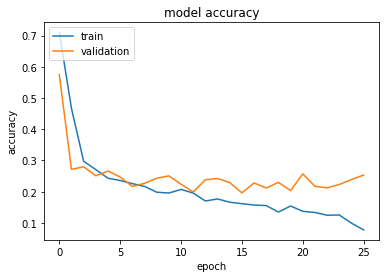

Train loss: 0.122110011722
Train accuracy: 0.955906822063
Validation loss: 0.196221838988
Validation accuracy: 0.917910448058

===================FOLD= 1
0.001
Epoch 1/100
100/100 [==============================] - 10s 99ms/step - loss: 0.5027 - acc: 0.7443 - val_loss: 0.2347 - val_acc: 0.9052
Epoch 2/100
100/100 [==============================] - 10s 96ms/step - loss: 0.3055 - acc: 0.8536 - val_loss: 0.2244 - val_acc: 0.9127
Epoch 3/100
100/100 [==============================] - 10s 97ms/step - loss: 0.2564 - acc: 0.8816 - val_loss: 0.1752 - val_acc: 0.9377
Epoch 4/100
100/100 [==============================] - 9s 95ms/step - loss: 0.2588 - acc: 0.8782 - val_loss: 0.1662 - val_acc: 0.9327
Epoch 5/100
100/100 [==============================] - 9s 94ms/step - loss: 0.2269 - acc: 0.8957 - val_loss: 0.1566 - val_acc: 0.9401
Epoch 6/100
100/100 [==============================] - 9s 88ms/step - loss: 0.2159 - acc: 0.9046 - val_loss: 0.1709 - val_acc: 0.9377
Epoch 7/100
100/100 [============

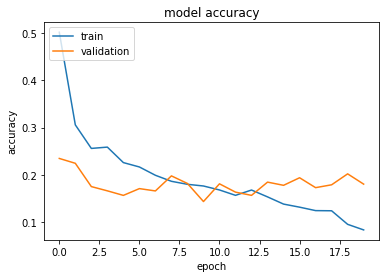

Train loss: 0.12221194748
Train accuracy: 0.950124688973
Validation loss: 0.143528042589
Validation accuracy: 0.945137157553

===================FOLD= 2
0.001
Epoch 1/100
100/100 [==============================] - 9s 95ms/step - loss: 0.3792 - acc: 0.8073 - val_loss: 0.2997 - val_acc: 0.8529
Epoch 2/100
100/100 [==============================] - 9s 94ms/step - loss: 0.2758 - acc: 0.8771 - val_loss: 0.2601 - val_acc: 0.8903
Epoch 3/100
100/100 [==============================] - 10s 96ms/step - loss: 0.2266 - acc: 0.8999 - val_loss: 0.2493 - val_acc: 0.8928
Epoch 4/100
100/100 [==============================] - 10s 97ms/step - loss: 0.2123 - acc: 0.9062 - val_loss: 0.2338 - val_acc: 0.9102
Epoch 5/100
100/100 [==============================] - 9s 91ms/step - loss: 0.1963 - acc: 0.9144 - val_loss: 0.2622 - val_acc: 0.8953
Epoch 6/100
100/100 [==============================] - 9s 91ms/step - loss: 0.1770 - acc: 0.9226 - val_loss: 0.2481 - val_acc: 0.9027
Epoch 7/100
100/100 [==============

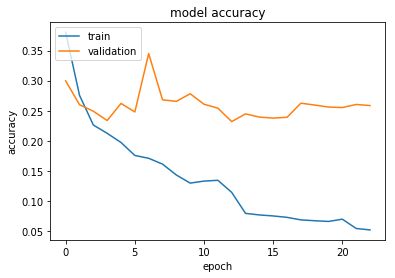

Train loss: 0.0697717480795
Train accuracy: 0.972568578554
Validation loss: 0.232032262551
Validation accuracy: 0.925187033014

===================FOLD= 3
0.001
Epoch 1/100
100/100 [==============================] - 10s 98ms/step - loss: 0.4823 - acc: 0.7424 - val_loss: 0.3013 - val_acc: 0.8700
Epoch 2/100
100/100 [==============================] - 9s 95ms/step - loss: 0.2655 - acc: 0.8792 - val_loss: 0.2984 - val_acc: 0.8700
Epoch 3/100
100/100 [==============================] - 9s 95ms/step - loss: 0.2389 - acc: 0.8948 - val_loss: 0.2879 - val_acc: 0.8750
Epoch 4/100
100/100 [==============================] - 9s 92ms/step - loss: 0.2215 - acc: 0.9048 - val_loss: 0.3721 - val_acc: 0.8275
Epoch 5/100
100/100 [==============================] - 10s 96ms/step - loss: 0.1980 - acc: 0.9196 - val_loss: 0.2478 - val_acc: 0.8925
Epoch 6/100
100/100 [==============================] - 9s 94ms/step - loss: 0.1851 - acc: 0.9231 - val_loss: 0.2345 - val_acc: 0.8975
Epoch 7/100
100/100 [============

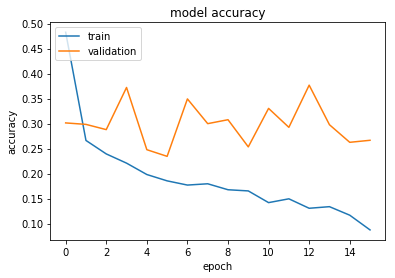

Train loss: 0.14403075663
Train accuracy: 0.946843854217
Validation loss: 0.234454018474
Validation accuracy: 0.8975

Log Loss Validation=  0.201535202775


In [42]:
# Repeat Each Training for 30 times and use statistics to get the score
preds,final_preds =myBaseCrossTrain(train_image, train_target,test_image,model=getVggModel(),splits=4)
# preds,final_preds =myBaseCrossTrain(train_image_resize, train_target,test_image_resize,model=getResNet50(),splits=2)

In [43]:
#Submission for each day.
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('vgg_reset_weight_4.csv', index=False)
                  
                  
#0.1639 on the public leaderboard
# gen = ImageDataGenerator(horizontal_flip = True,vertical_flip = True,width_shift_range = 0.,height_shift_range = 0.,channel_shift_range=0,zoom_range = 0.2,rotation_range = 10)
# galaxyModel.fit(X_train_cv, y_train_cv,batch_size=24,epochs=80,verbose=1,validation_data=(X_holdout, Y_holdout),callbacks=callbacks)

# Train loss: 0.0793685312089
# Train accuracy: 0.975913620866
# Test loss: 0.258395348191
# Test accuracy: 0.895
# Log Loss Validation= 0.211045624827

In [53]:
# sub1 = pd.read_csv('resnet_sub.csv')
sub2 = pd.read_csv('vgg_sub.csv')
sub3 = pd.read_csv('vgg_reset_weight_4_0.1658.csv')
sub4 = pd.read_csv('sub0.1639.csv')



In [60]:
cb = sub2.set_index('id').join(sub3.set_index('id'),rsuffix='_1').join(sub4.set_index('id'),rsuffix='_3')

In [65]:
cb['mean'] = cb.mean(axis=1)
cb['median'] = cb.median(axis=1)

In [67]:
cb.reset_index(inplace=True)

In [69]:
sb1 = cb[['id','mean']]
sb2 = cb[['id','median']]

sb1.columns = ['id','is_iceberg']
sb2.columns = ['id','is_iceberg']

In [71]:
sb1.to_csv('stack1.csv',index=False)
sb2.to_csv('stack1.csv',index=False)

## Option 1
* Learning Rate - Set low than move on to high than reduce when starting to overfit
* Add more Data
* Data Augmentation
* Batch Normalization
* Add Dropout / Regularization

In [ ]:
# Splitting to test set and training set -- Option 1

indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = target_train[indices]
nb_validations_samples = int(0.3*X_train.shape[0])
X_val = X_train[-nb_validations_samples:]
# y_val = to_categorical(y_train[-nb_validations_samples:])
y_val = y_train[-nb_validations_samples:]

X_train = X_train[:-nb_validations_samples]
# y_train = to_categorical(y_train[:-nb_validations_samples])
y_train = y_train[:-nb_validations_samples]

In [ ]:
# Splitting to test set and training set -- Option 2

from sklearn.model_selection import train_test_split

# X_train, X_valid, X_angle_train, X_angle_valid, y_train, y_valid = train_test_split(X_train,
#                                     X_angle_train, y_train, random_state=123, train_size=0.75)


X_train, X_val, X_ang,X_ang_val,y_train, y_val = train_test_split(train_image,train_angle,train_target,random_state=123,test_size=0.3)

In [ ]:
gen = ImageDataGenerator(rotation_range = 10)

In [ ]:
BATCH_SIZE = 64
# STEPS_PER_EPOCH = X_train.shape[0] // BATCH_SIZE
STEPS_PER_EPOCH = 100
model = getVggModel()
model.fit_generator(gen.flow(X_train,y_train,batch_size=BATCH_SIZE)
                    ,steps_per_epoch=STEPS_PER_EPOCH,epochs=5,verbose=1,validation_data=(X_val, y_val))

In [ ]:
model.optimizer.lr = 1e-4

In [86]:
model.fit_generator(gen.flow(X_train,y_train,batch_size=BATCH_SIZE)
                    ,steps_per_epoch=STEPS_PER_EPOCH,epochs=5,verbose=1,validation_data=(X_val, y_val)
                    ,callbacks=callbacks)

Epoch 1/5
100/100 [==============================] - 14s - loss: 0.2252 - acc: 0.9096 - val_loss: 0.2143 - val_acc: 0.9044
Epoch 2/5
100/100 [==============================] - 14s - loss: 0.2095 - acc: 0.9143 - val_loss: 0.3369 - val_acc: 0.8711
Epoch 3/5
100/100 [==============================] - 14s - loss: 0.2002 - acc: 0.9210 - val_loss: 0.2279 - val_acc: 0.9044
Epoch 4/5
100/100 [==============================] - 14s - loss: 0.1955 - acc: 0.9202 - val_loss: 0.2128 - val_acc: 0.9064
Epoch 5/5
100/100 [==============================] - 15s - loss: 0.1901 - acc: 0.9239 - val_loss: 0.2429 - val_acc: 0.9064


In [88]:
preds = model.predict(X_test)
preds = preds.reshape(preds.shape[0])

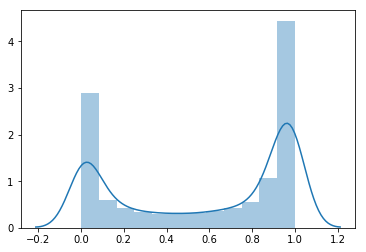

In [101]:
import seaborn as sb
sb.distplot(preds)

In [40]:
#Submission for each day.
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('sub.csv', index=False)